## 决策树和 K 近邻分类

---

#### 介绍

本次实验分别运用决策树和最近邻方法在分类任务上构建模型，并通过交叉验证对模型进行调优。

#### 知识点

- 决策树
- 最近邻方法
- 交叉验证

---

### 机器学习介绍

在深入本次实验之前，首先了解一下什么是机器学习， Machine Learning（T. Mitchell 著，1997 年出版）一书中给出了机器学习经典、通用的定义：

>假设用 P 来评估计算机程序在某任务类 T 上的性能，若一个程序利用经验 E 在任务 T 上获得了性能改善，则我们就说关于 T 和 P, 该程序对 E 进行了学习。

在不同的问题设定下，T、P、E 可能指完全不同的东西。机器学习中一些流行的任务 T 包括：
- 分类：基于特征将实例分为某一类。
- 回归：基于实例的其他特征预测该实例的数值型目标特征。
- 聚类：基于实例的特征实现实例的分组，从而让组内成员比组间成员更为相似。
- 异常检测：寻找与其他样本或组内实例有很大区别的实例。
- 其他更多任务

关于经验 E，《Deep Learning》（Ian Goodfellow、Yoshua Bengio、Aaron Courville 著，2016 年出版）的「Machine Learning basics」一章提供了一份很好的综述：

>经验 E 指的是数据（没有数据我们什么也干不了）。根据训练方式，机器学习算法可以分为监督（supervised）和无监督（unsupervised）两类。无监督学习需要训练含有很多特征的数据集，然后学习出这个数据集上有用的结构性质。而监督学习的数据集除了含有很多特征外，它的每个样本都要有一个标签（label）或目标（target）。

#### 示例

分类和回归属于监督学习问题。例如，作为信贷机构，我们可能希望根据客户累积的数据预测贷款违约情况。在这里，经验 E 是已有的训练数据，即实例（客户）的集合，一组特征（例如年龄、薪水、贷款类型、以往违约记录等），一个目标变量（他们是否会违约）。由于需要预测的目标变量是「他们是否会违约」，所以这是一个二元分类问题。如果你转而预测贷款会超期多久，那么需要预测的目标变量变成了一个连续值（时间），这就成为一个回归问题了。

最后，关于算法表现的评估度量 P。不同问题和算法的度量不同，当学习新算法时，我们将讨论这一点。就目前而言，本次实验将使用分类算法中的一个简单度量标准，即准确率（Accuracy）。

下面看看分类和回归这两个监督学习问题。

### 决策树

决策树是分类与回归问题中常用的方法之一。其实不仅是机器学习领域，在每天的日常决策中，我们都在使用决策树。流程图实际上就是决策树的可视化表示，例如，下面是俄罗斯国立高等经济研究大学（Higher School of Economics）提供的关于「如何在学院网站上发表论文」的流程图：

<img width='500px;' src='images/high_school_of_economics.png'>

用机器学习的术语来说，可以把它看成一个简单的分类器，根据内容（书、小册子、论文）、新闻类型、原发表物类型（科学期刊、通讯）等来确定合适的发表类型（书、文章、书的章节、预印本、Higher School of Economics and the Media 稿件）。

决策树常常是专家经验的概括，是一种分享特定过程知识的方式。例如，在引入可扩展机器学习算法之前，银行业的信用评分任务是由专家解决的，能否放贷是基于一些直观（或经验）的规则，这些规则就可以表示为决策树的形式，如下图所示：

<img src="images/bank_debt.png">

作为机器学习算法的决策树基本上和上图差不多，它合并一连串逻辑规则，使之成为一个树形的数据结构，这些规则的形式为「特征 a 的值小于 x，特征 b 的值小于 y … => 类别 1」。

下面，我们基于「年龄」、「房产」、「收入」、「教育」特征使用决策树解决一个二元分类问题，即「是否允许贷款」。

### 如何构建决策树

年龄、房产、收入、教育，这么多的特征首先应该关注哪个呢？

为了回答上述问题，先看一个简单的游戏，即「20个问题」游戏，这个游戏是这样玩的：A 心里想着一个名人，B 问 A 20 个问题，A 只能回答「是」或「否」，20 个问题之后 B 要猜出 A 心里想的那个名人是谁。首先问一个可以最大程度压缩剩余选项数目的问题会使 B 占据极大优势，例如询问「是不是安吉丽娜·朱莉？」，最多剔除一个选项，而询问「这个名人是女人吗？」将消除大约一半的选项。就是说，「性别」特征相比「安吉丽娜·朱莉」、「西班牙人」、「喜欢足球」等其他特征更能区分名人数据集。这背后的道理与熵有关，下面介绍熵的概念。

#### 熵

熵是一个在物理、信息论和其他领域中广泛应用的重要概念，可以衡量获得的信息量。对于具有 N 种可能状态的系统而言，熵的定义如下：
$$S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$

其中，$p_i$ 是系统位于第 i 个状态的概率。熵可以描述为系统的混沌程度，熵越高，系统的有序性越差，反之亦然。熵将帮助我们高效的分割数据，类似帮助我们找出在「20个问题」游戏中先问什么问题较好。

#### 玩具示例

为了解释熵是如何有利于构建决策树模型的，让我们来看一个玩具示例，在这个示例中将基于球的位置预测它的颜色。

<img src='images/toy_sample.png'>

这里有 9 个蓝球和 11 个黄球。如果随机选择一个球，这个球是蓝球的概率 $p_1=\frac{9}{20}$，是黄球的概率 $p_2=\frac{11}{20}$，这意味着熵 $S_0 = -\frac{9}{20}\log_2{\frac{9}{20}}-\frac{11}{20}\log_2{\frac{11}{20}} \approx 1$。这个值本身可能无法告诉我们很多信息。

将球分为「位置小于等于 12、位置大于 12」这两组，如下图所示。

<img src='images/two_group.png'>

那么分组后，熵的变化如何？左边一组有 13 个球， 8 蓝 5 黄。这一组的熵 $S_1 = -\frac{5}{13}\log_2{\frac{5}{13}}-\frac{8}{13}\log_2{\frac{8}{13}} \approx 0.96$。右边一组有 7 个球， 1 蓝 6 黄。右边这组的熵 $S_2 = -\frac{1}{7}\log_2{\frac{1}{7}}-\frac{6}{7}\log_2{\frac{6}{7}} \approx 0.6$。可见，两组的熵都下降了，且右边这组降得更多。由于熵实际上是系统混沌（或不确定）的程度，熵的下降被称为信息增益。数学上，基于变量 Q（在这个例子中是变量「x ≤ 12」）所作的分割，得到的信息增益（IG）定义为：
$$IG(Q) = S_0 - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$

其中，$q$ 是分割的组数，$N_i$ 是变量 Q 等于第 i 项时的样本数目。在玩具示例中，有 2 个组（$q = 2$），一组有 13 个元素（$N_1 = 13$），另一组有 7 个（$N_2 = 7$）。因此，信息增益为：

$$ IG(x \leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$

结果表明，根据「坐标小于或等于12」将球分为两组带来了一个更有序的系统。让我们继续分组，直到每组中的球颜色都一样。

<img src='images/toy_desicion_tress.png'>

上图可见，右边那组只需根据「坐标小于或等于 18」再分割一次即可。而左边那组还需要三次分割。注意，若组内所有球的颜色都一样，那么这个组的熵为 0（$\log_2{1} = 0$）。

通过这个例子，我们成功构建了一个基于球的位置预测球颜色的决策树。但倘若我们再向里面增加一个球，这个决策树就可能无法很好地工作，因为它完全拟合了训练集（初始的 20 球）。如果希望提升它的泛用性，那么一棵具有更少分支（「问题」）的决策树将有更好的效果。

### 决策树构建算法

在之前的例子中构建的决策树是最优的：它只需提 5 个「问题」（基于变量 Q），就完全拟合了训练集。其他分割条件会使得到的树更深，即需要更多「问题」才能获得答案。

构建决策树的流行算法（如 ID3 或 C4.5）的核心，是贪婪最大化信息增益：在每一步，算法都会选择能在分割后给出最大信息增益的变量。接着递归重复这一流程，直到熵为零（或者，为了避免过拟合，直到熵为某个较小的值）。不同的算法使用不同的推断，通过「提前停止」或「截断」以避免构建出过拟合的树。

### 分类问题中其他的分割质量标准

上面我们讨论了熵是如何衡量树的分区的，但还有其他指标来衡量分割的好坏：
- 基尼不确定性（Gini uncertainty）：$G = 1 - \sum\limits_k (p_k)^2$
- 错分率（Misclassification error）：$E = 1 - \max\limits_k p_k$

实践中几乎从不使用错分率，而基尼不确定性和信息增益的效果差不多。

 二元分类问题的熵和基尼不确定性为：
 $$ \begin{array}{ll}
 S &= -p_+ \log_2{p_+} -p_- \log_2{p_-} \\
 &= -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})}\\
 G &= 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+)
 \end{array}$$

其中 $p_+$ 是对象具有标签 + 的概率。

以 $p_+$ 为坐标，绘制上面两个函数的图像。

In [58]:
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')


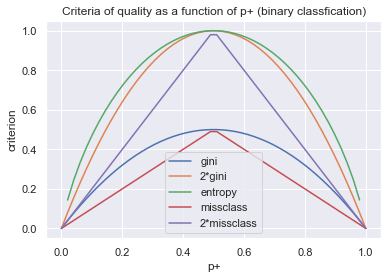

In [59]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2*x*(1-x) for x in xx], label='gini')
plt.plot(xx, [4*x*(1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x*np.log2(x)-(1-x)*np.log2(1-x) for x in xx], label='entropy')
plt.plot(xx, [1-max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2-2*max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Criteria of quality as a function of p+ (binary classfication)')
plt.legend()


上图可见，熵的图像和两倍的基尼不确定性图像非常接近。因此，在实践中，这两个指标的效果基本上是一样的。

#### 示例

下面用一棵决策树拟合一些合成数据。这些合成数据属于两个不同的类别，这两个类别的均值不同，但都呈现正态分布。

In [60]:
# 第一类
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# 第二类
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]


下面绘制数据。通俗地讲，这种情况下的分类问题就是构造一个「边界」，能够较好的分开两个类别（红点和黄点）。这个「边界」若是一条直线的话可能太过简单，若是沿着每个红点画出的蛇形曲线又太过复杂（这将导致其在新数据上的表现很差）。从直觉上说，某种平滑的边界，在新数据上的效果会比较好。

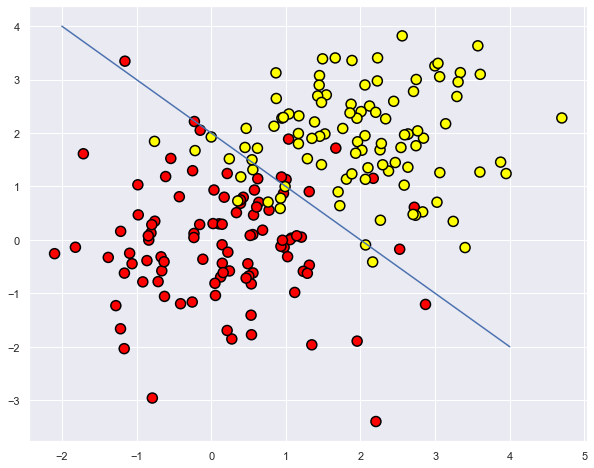

In [61]:
plt.figure(figsize=(10, 8))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels,
            s=100, cmap='autumn', edgecolors='black', linewidths=1.5)
plt.plot(range(-2, 5), range(4, -3, -1))


下面训练一棵 sklearn 决策树，区分这两类数据点。最后可视化所得的边界。

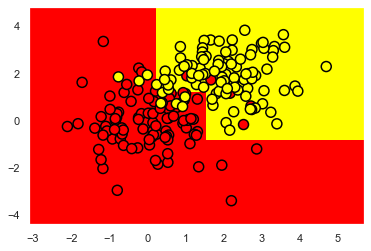

In [62]:
from sklearn.tree import DecisionTreeClassifier
# 编写一个辅助函数，返回之后的可视化网格


def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


#  max_depth参数限制决策树的深度
clf_tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=3, random_state=17)

# 训练决策树
clf_tree.fit(train_data, train_labels)

# 可视化
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels,
            s=100, cmap='autumn', edgecolors='black', linewidths=1.5)


通过 pydotplus 和 export_graphviz 库我们可以方便的看到决策树本身是怎样的。使用 `StringIO()` 函数开辟一个缓存空间保存决策树，通过 `export_graphviz()` 函数以 DOT 格式导出决策树的 GraphViz 表示，然后将其写入 out_file 中。使用 `graph_from_dot_data()` 函数读入数据并通过 `Image()` 函数显示决策树。

In [63]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=[
                'x1', 'x2'], out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05,\x00\x00\x01\xf1\x08\x02\x00\x00\x00\xe8feQ\x00\…

上图表明，在最深的一层，树将空间「切割」为8个矩形，也就是说，树有8个叶节点。在每个矩形之中，树将根据数量较多的对象的标签做出预测。

### 我们如何「读懂」这颗决策树？

上个示例中，总共有 200 个合成数据（样本），每个分类各有 100 个合成数据。初始状态的熵是最大的，即 $S=1$。接着，通过比较 $x_2$ 与 1.211 的大小进行第一次分割，将样本分成两组（你可以在上图中找到这一部分边界）。基于这一次分割，左右两组的熵都下降了。这一过程持续进行，直到树的深度达到 3。在上图中，属于第一类的样本数量越多，该节点的橙色就越深，属于第二类的样本越多，该节点的蓝色就越深。若两类样本的数量相等，则为白色，比如根节点的两类样本数量相同，所以它是白色的

### 决策树如何应用到数值特征？

假设有一个数值特征「年龄」，该特征有大量的唯一值。决策树将通过查看「年龄 < 17」、「年龄 < 22.87」这样的二元属性寻找最好的分割，分割的好坏由某种信息增益标准衡量。但在构建树的每一步中，会有过多的二元属性可供选择，比如「薪水」同样能以很多方式进行分割，为了解决这一问题，我们经常使用启发式算法来限制选择的属性数量。

看一个例子，假设有如下数据集：

In [64]:
data = pd.DataFrame({'Age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33], 'Loan Default': [
                    1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data


,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


使用 `sort_values()` 方法根据年龄进行升序排列。

In [65]:
data.sort_values('Age')


,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


训练一个决策树模型，并可视化。

In [66]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Age'].values.reshape(-1, 1), data['Loan Default'].values)
dot_data = StringIO()
export_graphviz(age_tree, feature_names=[
                'Age'], out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\t\x00\x00\x03\x07\x08\x06\x00\x00\x00\xb3\x1f\xc…

上图可见，该决策树使用以下 5 个值来评估年龄：43.5、19、22.5、30、32。如果你仔细观察，你会发现它们就是目标变量（Loan Default）出现变化（从 1「切换」到 0 或从 0「切换」到 1）时那两个年龄的平均值。比如，一个 38 岁的客户没能偿还贷款（目标变量为 1），而一个 49 岁的客户还贷了（目标变量为 0），那么树使用的评估值就是 38 和 49 的均值，即 43.5。树寻找那些目标变量发生变化的值，以此作为「切割」的阈值。

In [67]:
data2 = pd.DataFrame({'Age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33], 'Salary': [
                     25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88], 'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data2.sort_values('Age')


,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


上表可见，如果根据年龄排序，目标变量（Loan Default）将切换（从 1 到 0 或从 0 到 1）5 次。

下表可见，如果根据薪水排序，它将切换 7 次。

In [68]:
data2.sort_values('Salary')


,Age,Salary,Loan Default
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


下面看看树将如何选择特征。

In [69]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Age', 'Salary']].values, data2['Loan Default'].values)

dot_data = StringIO()
export_graphviz(age_sal_tree, feature_names=['Age', 'Salary'], out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x15\x00\x00\x02|\x08\x02\x00\x00\x00\xc6}\xc4\xb…

上图表明，树同时根据薪水和年龄进行分区，有些节点的分割阈值选择了年龄，有些选择了薪水。树为何选择这些特征？因为根据基尼不确定性质量标准，它们提供了更好的分区。

结论：决策树处理数值特征最简单的启发式算法是升序排列它的值，然后只关注目标变量发生改变的那些值。

此外，当数据集具有大量数值特征，且每个特征具有大量唯一值时，只选择最高的N个阈值，即，仅仅使用提供最高增益的前N个值。这一过程可以看成是构造了一棵深度为 1 的树，计算熵（或基尼不确定性），然后选择最佳阈值用于比较。比方说，如果我们根据「薪水 ≤ 34.5」分割，左子组的熵为 0（所有客户都是「不好的」），而右边的熵为 0.954（3 个「不好的」，5 个「好的」，你可以自行确认这一点，这将作为作业的一部分），信息增益大概是 0.3。如果我们根据「薪水 ≤ 95」分割，左边的子组的熵会是 0.97（6 个「不好的」，4 个「好的」），而右边的熵会是 0（该组只包含 1 个对象），信息增益大约是  0.11。如果以这样的方式计算每种分区的信息增益，那么在使用所有特征构造一棵大决策树之前就可以选出每个数值特征的阈值。

### 树的关键参数

理论上讲，我们可以构建一个决策树，直到每个叶节点只有一个实例，但这样做容易过拟合，导致其在新数据上的表现不佳。如果你这么做，在树的最深处，可能会存在由无关紧要的特征组成的分区，例如根据「客户裤子的颜色」这一特征进行分区，这是我们不希望发生。

但在两种情况下，树可以被构建到最大深度（每个叶节点只有一个实例）：
- 随机森林。它将构建为最大深度的单个树的响应进行平均（稍后我们将讨论为什么要这样做）。
- 决策树修剪。在这种方法中，树首先被构造成最大深度。然后，从底部开始，基于交叉验证来比较有分区/无分区情形下树的质量情况，进而移除树的一些节点。

下图是过拟合的决策树给出的分界。

<img width='400px;' src='images/decision_tree_overfit.png'>

常见的解决决策树过拟合的方法为：
- 人工限制深度或叶节点的最少样本数。

- 对树进行剪枝。

### scikit-learn 的 DecisionTreeClassifier 类

sklearn.tree.DecisionTreeClassifier 类的主要参数为：
- max_depth 树的最大深度；
- max_features 搜索最佳分区时的最大特征数（特征很多时，设置这个参数很有必要，因为基于所有特征搜索分区会很「昂贵」）；
- min_samples_leaf 叶节点的最少样本数。

树的参数需要根据输入数据设定，通常通过交叉验证可以确定参数范围，下文会具体讨论交叉验证。

### 回归问题中的决策树

当对数值变量进行预测时，我们构造决策树的思路和分类问题时所用的思路是一样的，但衡量决策树好坏的质量标准改变了，现在它的质量标准如下：
$$D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$

其中，$\ell$ 是叶节点中的样本数，$y_i$ 是目标变量的值。简单来说，通过最小化方差，使每个叶子中的目标特征的值大致相等，以此来划分训练集的特征。

#### 示例

让我们基于以下函数生成一些带噪数据：
$$f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$$

接着在生成的数据上训练一颗决策树，并进行预测，调用 `plt` 方法画出结果示意图。

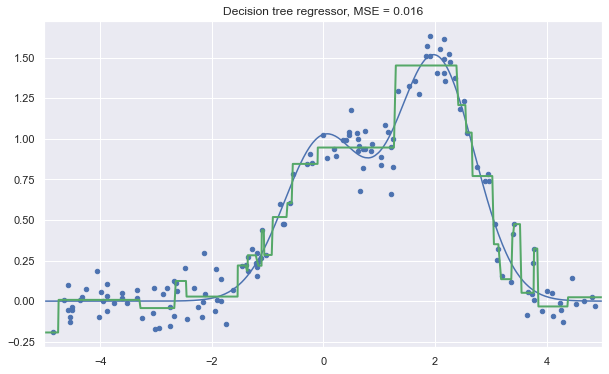

In [72]:
from sklearn.tree import DecisionTreeRegressor
n_train = 150
n_test = 1000
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-x**2)+1.5*np.exp(-(x-2)**2)


def generate(n_samples, noise):
    X = np.random.rand(n_samples)*10-5
    X = np.sort(X).ravel()
    y = np.exp(-X**2)+1.5*np.exp(-(X-2)**2) + \
        np.random.normal(0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, reg_tree_pred, 'g', lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = {:.2}".format((np.sum(y_test-reg_tree_pred)**2)/n_test))
plt.show()


上图表明，决策树使用分段的常数函数逼近数据。